In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torchinfo
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision import models
from torchvision.models import resnet50
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

In [2]:
home_folder = ''

In [3]:
data_folder = home_folder + 'data/'
images_folder = data_folder + 'images/'

In [4]:
train = pd.read_csv(data_folder + 'train.csv')
test = pd.read_csv(data_folder + 'test.csv')
X_id = train['id']
y_id = train['class']
X_id_train, X_id_val, y_id_train, y_id_val = train_test_split(X_id, y_id, random_state=42, test_size=0.2, stratify=y_id)

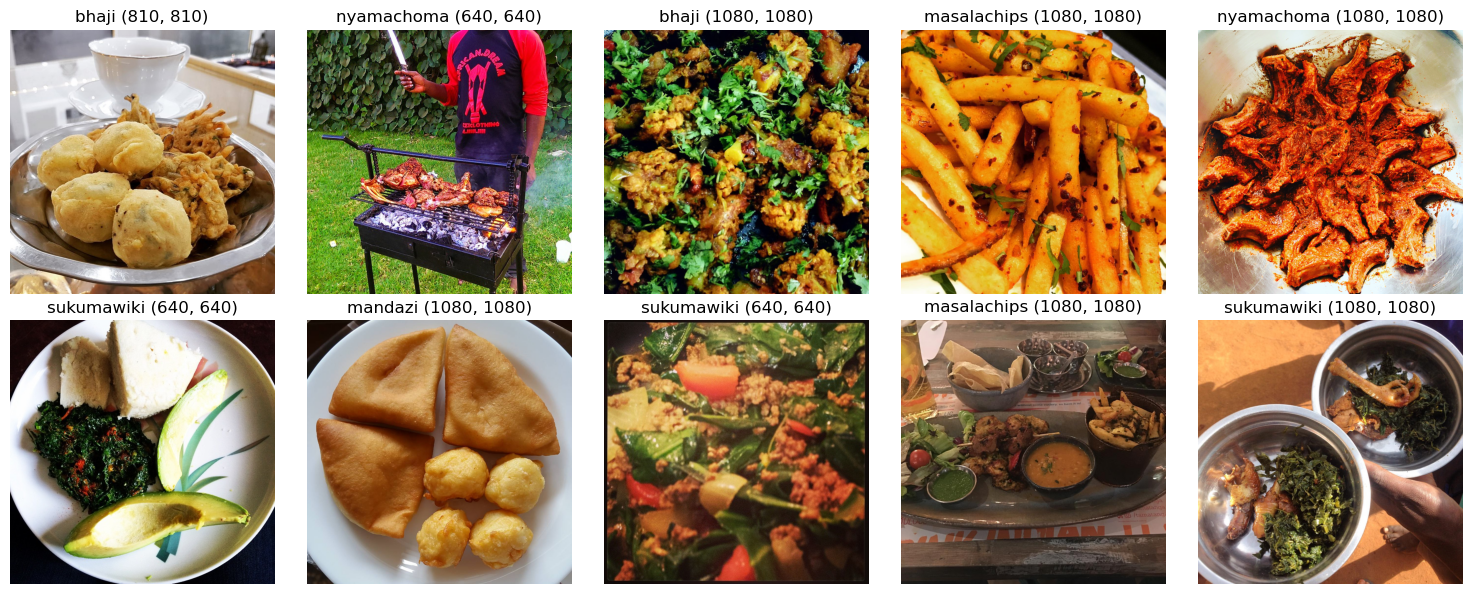

In [5]:
plt.figure(figsize=(15, 6))
for i, row in train.sample(10).reset_index(drop=True).iterrows():
    img_path = f'{images_folder}{row['id']}.jpg'
    img = Image.open(img_path)
    img_width, img_height = img.size
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{row['class']} ({img_width}, {img_height})')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
def image_preprocess_transforms(img_size):
    return T.Compose([
        T.Resize((img_size, img_size), antialias=True),
        T.ToTensor(),
    ])

In [6]:
def get_resnet50(num_classes):
    model_resnet50 = resnet50(weights="DEFAULT")

    for params in model_resnet50.parameters():
        params.requires_grad = False

    for params in model_resnet50.layer4.parameters():
        params.requires_grad = True

    model_fc_in_features = model_resnet50.fc.in_features
    model_resnet50.fc = nn.Linear(in_features=model_fc_in_features, out_features=num_classes)

    return model_resnet50

In [7]:
class DatasetTransforms(Dataset):
    def __init__(self, dataset, transform, classes, class_to_idx):
        self.dataset = dataset
        self.transforms = transform
        self.classes = classes
        self.class_to_idx = class_to_idx

    def __getitem__(self, idx):
        image, target = self.dataset[idx]

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.dataset)

In [8]:
class ClassLabeledImagesDataset(Dataset):
    """
    Dataset from two pandas Series:
      - x: image IDs
      - y: class names (strings)
    """
    def __init__(self, x, y, class_to_idx, transform):
        assert len(x) == len(y), "x and y series must be same length"
        self.x = x.reset_index(drop=True)
        self.y = y.reset_index(drop=True).map(class_to_idx)
        self.transform = transform

        self._paths = []
        for id in self.x:
            path = f'{images_folder}{id}.jpg'
            if not path.exists():
                raise FileNotFoundError(f"Image not found: {path}")
            self._paths.append(path)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx: int):
        return self.transform(Image.open(self._paths[idx]).convert("RGB")), self.y[idx]

In [26]:
class ResNetFineTuningModule(pl.LightningModule):
    def __init__(
        self,
        resnet_model_name="resnet50",
        weights="DEFAULT",
        fine_tune_start=4,
        learning_rate=0.01,
        num_classes=13,
    ):
        super().__init__()

        self.save_hyperparameters()

        resnet = getattr(models, self.hparams.resnet_model_name)(weights=self.hparams.weights)

        if self.hparams.weights:
            for param in resnet.parameters():
                param.requires_grad = False

            if self.hparams.fine_tune_start <= 1:
                for param in resnet.layer1.parameters():
                    param.requires_grad = True

            if self.hparams.fine_tune_start <= 2:
                for param in resnet.layer2.parameters():
                    param.requires_grad = True

            if self.hparams.fine_tune_start <= 3:
                for param in resnet.layer3.parameters():
                    param.requires_grad = True

            if self.hparams.fine_tune_start <= 4:
                for param in resnet.layer4.parameters():
                    param.requires_grad = True

        last_layer_in = resnet.fc.in_features
        resnet.fc = nn.Linear(last_layer_in, self.hparams.num_classes)

        self.resnet = resnet

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        output = self(data)
        loss = F.cross_entropy(output, target)
        pred_batch = output.detach().argmax(dim=1)
        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_acc(pred_batch, target)

        # Arguments such as on_epoch, on_step and logger are set automatically depending on
        # the hook methods they've been called from
        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=True)

        # logging and adding current batch_acc to progress_bar
        self.log("train/batch_acc", self.mean_train_acc, prog_bar=True, logger=True)
        return loss


    def on_train_epoch_end(self):
        # Calculate epoch level metrics for the train set
        self.log("train/loss", self.mean_train_loss, prog_bar=True, logger=True)
        self.log("train/acc", self.mean_train_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)


    def validation_step(self, batch, *args, **kwargs):
        data, target = batch
        output = self(data)
        loss = F.cross_entropy(output, target)
        pred_batch = output.argmax(dim=1)

        # Update logs
        self.mean_valid_loss(loss, weight=data.shape[0])
        self.mean_valid_acc(pred_batch, target)


    def on_validation_epoch_end(self):
        # Calculate epoch level metrics for the validation set
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True, logger=True)
        self.log("valid/acc", self.mean_valid_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)

In [ ]:
class KenyanFoodsDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_workers, img_size=224):

        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers

        mean = #[0.485, 0.456, 0.406]
        std = #[0.229, 0.224, 0.225]

        self.preprocess_transforms = T.Compose([
            T.Resize((img_size, img_size), antialias=True),
            T.ToTensor(),
        ])

        self.common_transforms = T.Compose([
            self.preprocess_transforms,
            T.Normalize(mean, std)
        ])

        self.aug_transforms = T.Compose([
            T.RandomResizedCrop(256),
            T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(90),
            T.RandomGrayscale(p=0.1),
            self.common_transforms,
            T.RandomErasing(),
        ])

    def prepare_data(self):
        train = pd.read_csv(data_folder + 'train.csv')
        X_id = train['id']
        y_id = train['class']
        X_id_train, X_id_val, y_id_train, y_id_val = train_test_split(X_id, y_id, random_state=42, test_size=0.2, stratify=y_id)

        curr_dir = os.getcwd()
        print("Preparing Cat, Dog, Panda dataset")
        url = (
            "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1"
        )
        filename = os.path.join(curr_dir, r"animal-data.zip")
        root = curr_dir

        torchvision.datasets.utils.download_url(url, root, filename)

        with zipfile.ZipFile(filename, "r") as f:

            # list the folders present in the zipfile
            directories = [info.filename for info in f.infolist() if info.is_dir()]

            # index 1 contatins the name of the root directory we are interested in
            # ["/", "cat-dog-panda/", "cat-dog-panda/training", ...]
            self.data_root = os.path.join(curr_dir, directories[1])

            # if data has not been extracted already (useful when experimenting again)
            # avoids extracting if dataset already extracted before
            if not os.path.isdir(self.data_root):
                # extract the zipfile contents
                f.extractall(curr_dir)

        print("Preparation completed.")

    def setup(self, stage=None):
        train_data_path = os.path.join(self.data_root, "training")
        val_data_path = os.path.join(self.data_root, "validation")

        self.train_dataset = datasets.ImageFolder(
            root=train_data_path, transform=self.aug_transforms
        )
        self.val_dataset = datasets.ImageFolder(
            root=val_data_path, transform=self.common_transforms
        )

    def train_dataloader(self):
        # train loader
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        # validation loader
        test_loader = torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader